# Demo Notebook for MaskTerial Inference

In this notebook, we will demonstrate how to use the MaskTerial model for inference on a set of images. The notebook will load a pre-trained model, process images from a specified directory, and display the results.

In [1]:
import os
import sys

sys.path.append("..")

import cv2
import matplotlib.pyplot as plt
from maskterial import MaskTerial, load_models
from maskterial.structures import Flake

import numpy as np
import torch

## Parameters

The following parameters are used to configure the inference process:

| Parameter           | Value                  | Description                                                                                                                                                                                    |
| ------------------- | ---------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| MODEL_DIR           | "../data/models"       | Directory containing the trained models                                                                                                                                                        |
| IMAGE_DIR           | "./images/GrapheneH"   | Directory containing input images to process                                                                                                                                                   |
| MATERIAL            | "GrapheneH"            | Material type for classification (GrapheneH), this is used to locate the model file, you can also overwrite the `seg_model_root` path or the other `_model_root` paths to point to your models |
| SEG_MODEL           | "M2F" or None          | Segmentation model type (Mask-to-Flake)                                                                                                                                                        |
| CLS_MODEL           | "AMM" or "GMM" or None | Whether to use the AMM or GMM for classification                                                                                                                                               |
| PP_MODEL            | "L2" or None           | Whether to use or not use the Post-Processing model (L2)                                                                                                                                       |
| SCORE_THRESHOLD     | 0.1                    | Minimum confidence score for detections, this means the model needs to be at least 10% confident in a detection                                                                                |
| MIN_CLASS_OCCUPANCY | 0.5                    | Minimum class occupancy ratio for valid predictions, this means a detected instance must be at least 50% occupied by a single class, e.g. Monolayer                                            |
| SIZE_THRESHOLD      | 200                    | Minimum size (pixels) for detected flakes                                                                                                                                                      |
| DEVICE              | cuda/cpu               | Computing device (GPU if available, otherwise CPU)                                                                                                                                             |

Note:
The AMM and M2F models can be very slow on CPU, so it is recommended to use a GPU for inference. If you do not have a GPU, you can set the `DEVICE` parameter to "cpu" to run the models on CPU, but expect longer processing times.


In [2]:
MODEL_DIR = "../data/models"
IMAGE_DIR = "./images/GrapheneH"

MATERIAL = "GrapheneH"
SEG_MODEL = "M2F"
CLS_MODEL = "AMM"
PP_MODEL = None
SCORE_THRESHOLD = 0.1
MIN_CLASS_OCCUPANCY = 0.5
SIZE_THRESHOLD = 200

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seg_model_root = (
    os.path.join(MODEL_DIR, "segmentation_models", SEG_MODEL, MATERIAL)
    if SEG_MODEL
    else None
)
cls_model_root = (
    os.path.join(MODEL_DIR, "classification_models", CLS_MODEL, MATERIAL)
    if CLS_MODEL
    else None
)
pp_model_root = (
    os.path.join(MODEL_DIR, "postprocessing_models", PP_MODEL)
    if PP_MODEL is not None
    else None
)

In [3]:
def display_results(
    image: np.ndarray,
    flakes: list[Flake],
    colors: list[tuple[int, int, int]] = [
        (255, 0, 0),
        (0, 0, 255),
        (0, 255, 0),
        (0, 255, 255),
        (255, 0, 255),
        (255, 41, 255),
    ],
):
    for flake in flakes:
        mask = flake.mask.astype(np.uint8)
        class_id = int(flake.thickness)

        # Draw outline
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image, contours, -1, colors[class_id], 2)

        # Get bounding box
        x, y, w, h = cv2.boundingRect(mask)

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), colors[class_id], 2)

        # Add class label
        label = f"Class {class_id}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2

        # Get text size for background
        (text_width, text_height), baseline = cv2.getTextSize(
            label, font, font_scale, thickness
        )

        # Adjust text position to keep it within bounds
        text_y = y - 5 if y - text_height - 10 >= 0 else y + h + text_height + 5
        bg_y1 = text_y - text_height - 5 if y - text_height - 10 >= 0 else y + h
        bg_y2 = text_y + 5 if y - text_height - 10 >= 0 else y + h + text_height + 10

        # Draw background rectangle for text
        cv2.rectangle(image, (x, bg_y1), (x + text_width, bg_y2), colors[class_id], -1)

        # Draw text
        cv2.putText(
            image, label, (x, text_y), font, font_scale, (255, 255, 255), thickness
        )

    fig, axis = plt.subplots(1, 1, figsize=(12, 12), dpi=100)
    plt.imshow(image[:, :, ::-1])
    plt.axis("off")
    plt.show()

In [4]:
segmentation_model, classification_model, postprocessing_model = load_models(
    seg_model_type=SEG_MODEL,
    seg_model_root=seg_model_root,
    cls_model_type=CLS_MODEL,
    cls_model_root=cls_model_root,
    pp_model_type=PP_MODEL,
    pp_model_root=pp_model_root,
    device=DEVICE,
)

predictor = MaskTerial(
    segmentation_model=segmentation_model,
    classification_model=classification_model,
    postprocessing_model=postprocessing_model,
    score_threshold=SCORE_THRESHOLD,
    min_class_occupancy=MIN_CLASS_OCCUPANCY,
    size_threshold=SIZE_THRESHOLD,
    device=DEVICE,
)

Processing 17294f8a-1df7-427f-b8ed-ab54e1571960.jpg (1/10)
Detected 1 flake(s).


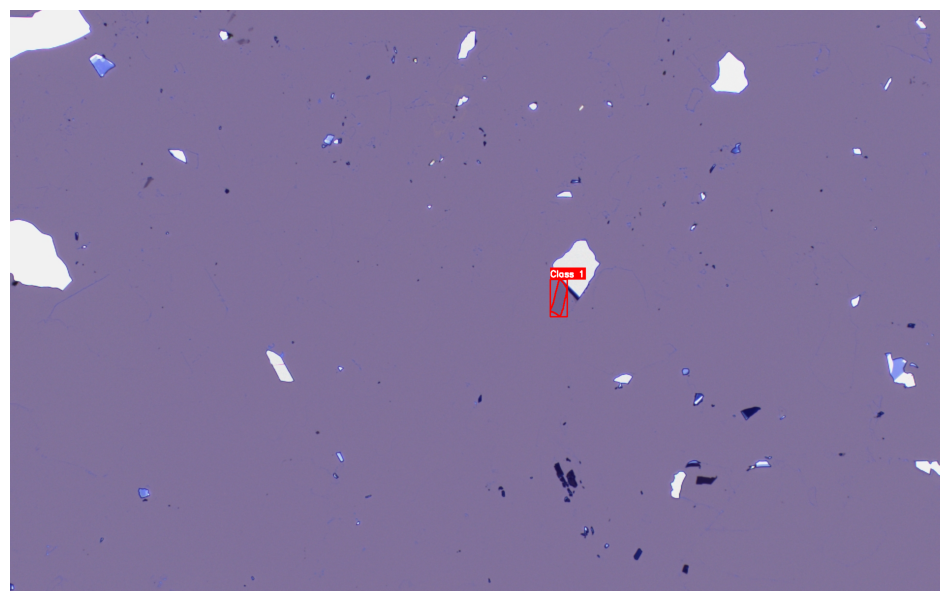

Processing 1fb9a0c6-da4a-4727-b9c0-473ddd7d0fd9.jpg (2/10)
Detected 1 flake(s).


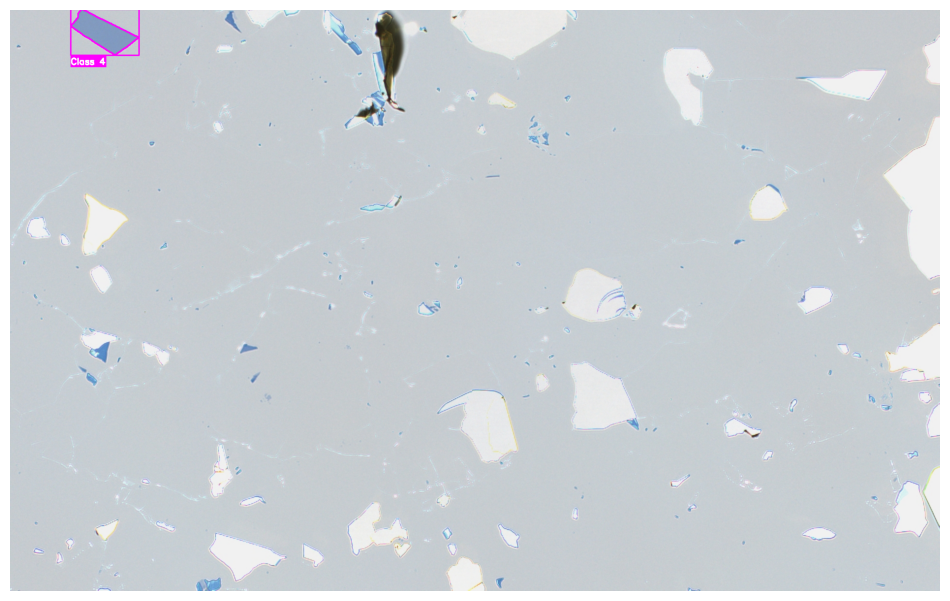

Processing 20ea4e7f-f2e3-40c8-829b-6e529b9dfc26.jpg (3/10)
Detected 3 flake(s).


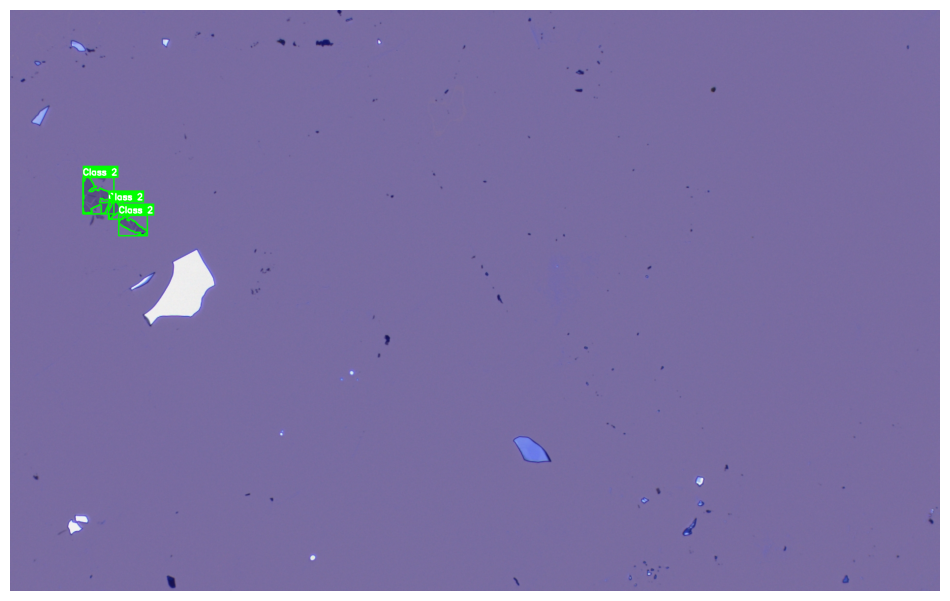

Processing 3659660c-e8bc-4199-8fe2-76384758cf2f.jpg (4/10)
Detected 4 flake(s).


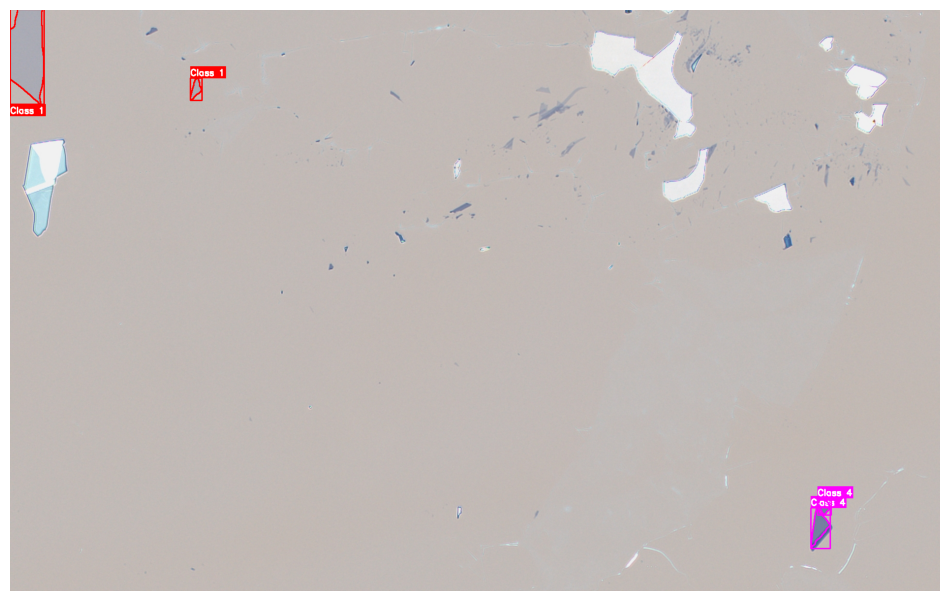

Processing 45ce9af7-5523-4aa2-9209-9639c3073766.jpg (5/10)
Detected 10 flake(s).


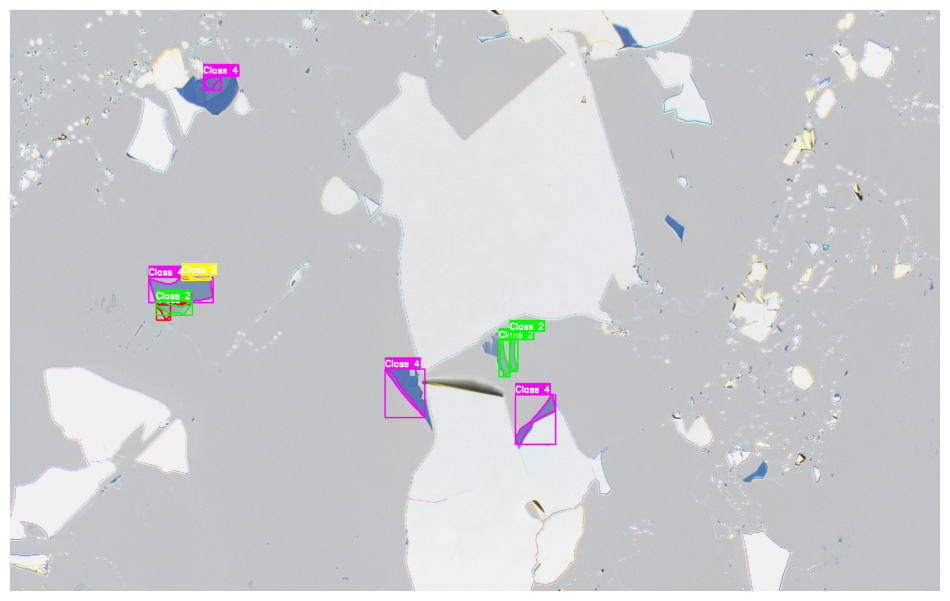

Processing 5e2efd44-1c3b-41ad-9eeb-b5f3f8597444.jpg (6/10)
Detected 1 flake(s).


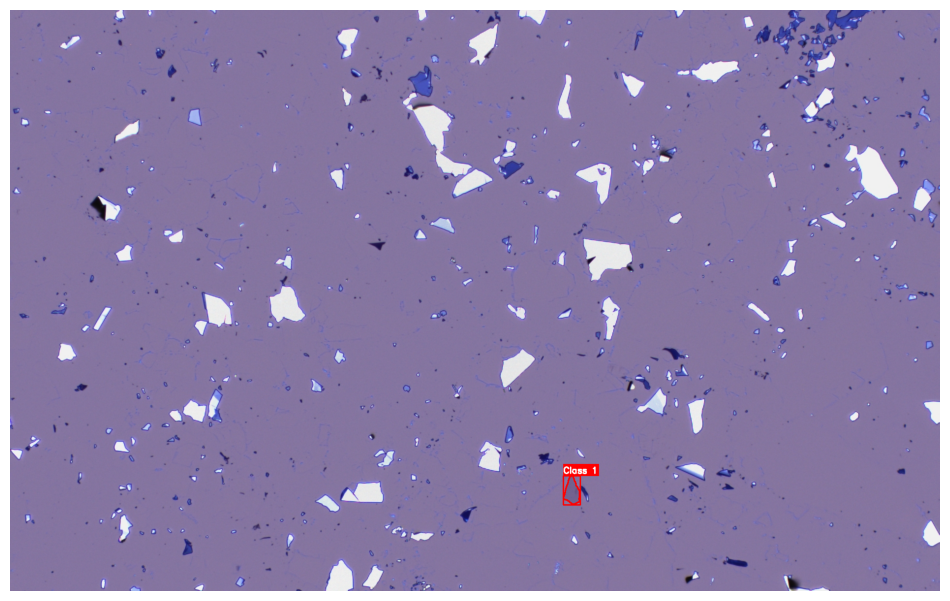

Processing 8e2d9357-cea9-403a-a131-303f690c136f.jpg (7/10)
Detected 6 flake(s).


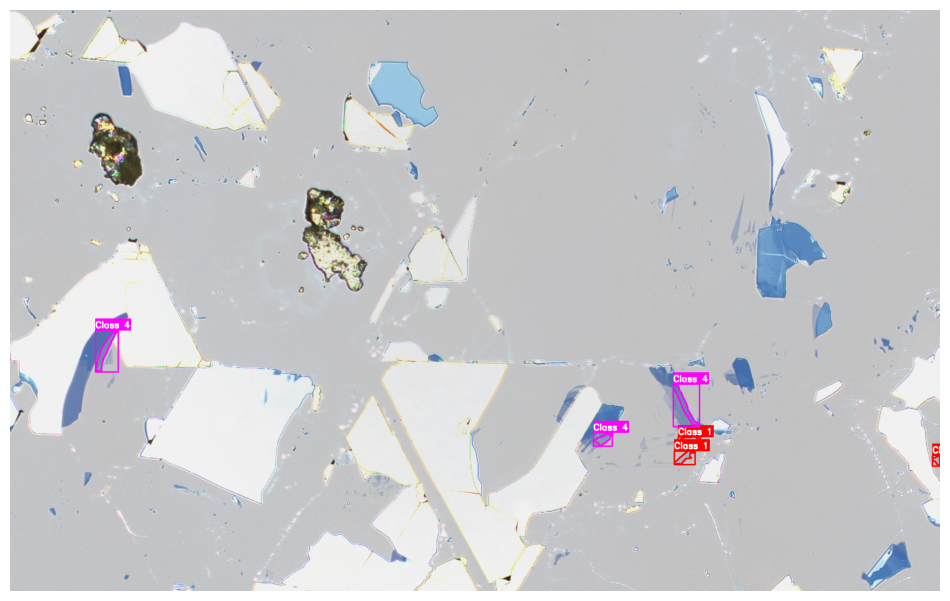

Processing 94fbb9f5-63a7-482f-92ba-ee2ccc6ef671.jpg (8/10)
Detected 1 flake(s).


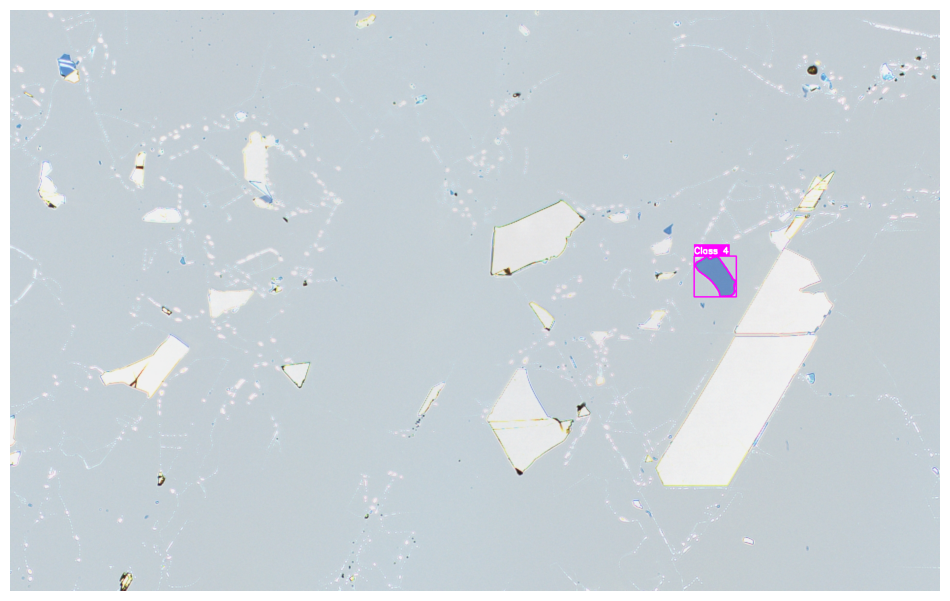

Processing acb69ba8-d9d9-45ef-a6d9-a26b1ba2471c.jpg (9/10)
Detected 2 flake(s).


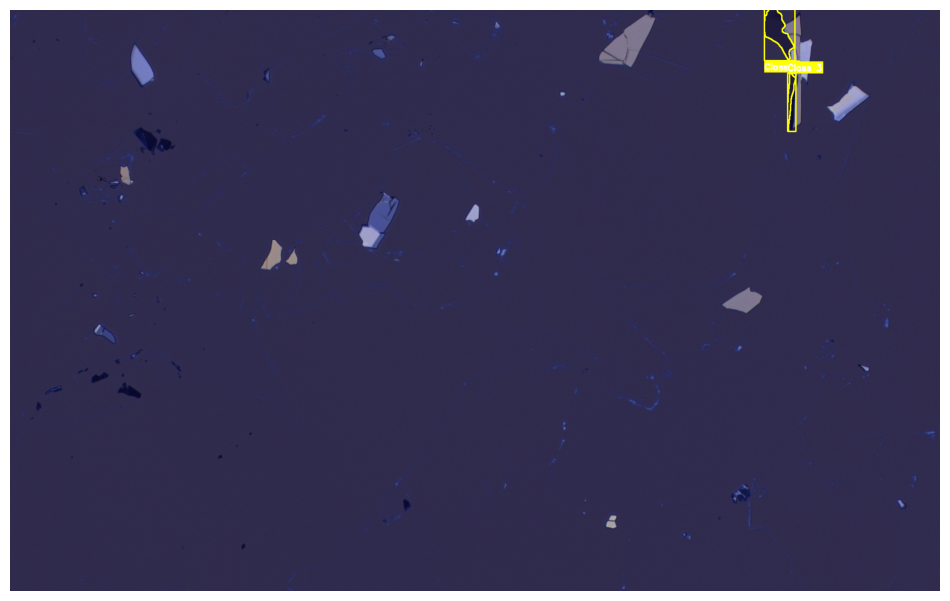

Processing e85b8fe6-3fc1-4c41-9690-8fcbe4e5db4c.jpg (10/10)
Detected 2 flake(s).


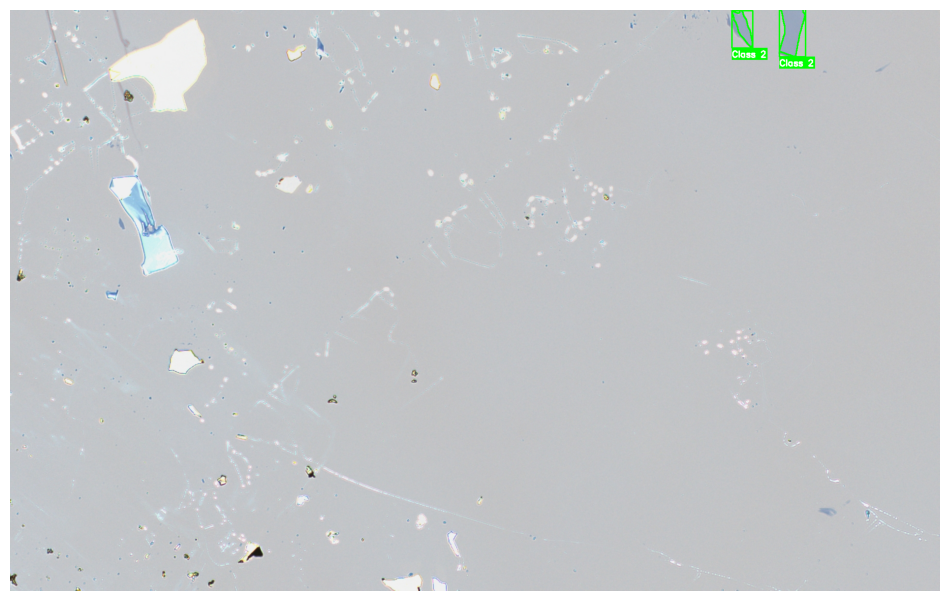

In [ ]:
image_names = [
    file for file in os.listdir(IMAGE_DIR) if file.endswith((".jpg", ".png", ".jpeg"))
]

for index, image_name in enumerate(image_names):
    print(f"Processing {image_name} ({index + 1}/{len(image_names)})")

    image_path = os.path.join(IMAGE_DIR, image_name)
    image = cv2.imread(image_path)
    flakes = predictor.predict(image)

    if len(flakes) == 0:
        print("No flakes detected, skipping...")
        continue
    print(f"Detected {len(flakes)} flake(s).")

    display_results(image, flakes)